In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 
    # Draw pose connections
    #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                         mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                         mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                         ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [6]:
def draw_styled_hand_landmarks(image, results):
    for hand_landmarks in results.multi_hand_landmarks:
                  mp_drawing.draw_landmarks(
                      image,
                      hand_landmarks,
                      mp_hands.HAND_CONNECTIONS,
                      mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                      mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [8]:
def extract_hand_keypoints(results):
    #lh = np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[0].landmark]).flatten() if len(results.multi_hand_landmarks) > 0 else np.zeros(21*3)
    #rh = np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[1].landmark]).flatten() if len(results.multi_hand_landmarks) > 1 else np.zeros(21*3)
    
    #return np.concatenate([lh, rh])
    lh = [[res.x, res.y, res.z] for res in results.multi_hand_landmarks[0].landmark] if len(results.multi_hand_landmarks) > 0 else [[0]*3]*21
    rh = [[res.x, res.y, res.z] for res in results.multi_hand_landmarks[1].landmark] if len(results.multi_hand_landmarks) > 1 else [[0]*3]*21
    ans = []
    ans.append(lh)
    ans.append(rh)
    return np.array(ans)

In [9]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [10]:
# Path for exported data, numpy arrays
# Step 4
DATA_PATH = os.path.join('dataset','letters_data')
actions = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
#actions = np.array(['A','B'])

# no of images
no_sequences = 1200#00

# no of frames in each video
#sequence_length = 30

In [11]:
# Step 6 - preprocess data create labels and features
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [13]:
input_images, image_labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        path = os.path.join(DATA_PATH, action, "{}.jpg".format(sequence))
        image = cv2.imread(path)
        input_images.append(image)
        image_labels.append(label_map[action])        

In [14]:
len(input_images)

31200

In [15]:
X, y = [], []
mapping = {}
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    for index in range(len(input_images)):
        img = input_images[index]
        image = cv2.flip(img, 1)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            draw_styled_hand_landmarks(image, results)
            keypoints = extract_hand_keypoints(results)
            X.append(keypoints)
            y.append(image_labels[index])
        else:
            if image_labels[index] not in mapping:
                mapping[image_labels[index]] = 0
            else:
                mapping[image_labels[index]] = mapping[image_labels[index]]+1

In [16]:
print(mapping)

{1: 20, 6: 0, 14: 35, 15: 68, 16: 357, 18: 10}


In [17]:
len(X)

30704

In [18]:
len(y)

30704

In [77]:
X_total = np.array(X)

In [78]:
y_total = to_categorical(y).astype(int) # y is a 1-hot representation of output label

In [79]:
y_total.shape

(30704, 26)

In [80]:
X_total.shape

(30704, 2, 21, 3)

In [82]:
def batch_generate(X, Y, batch_size):
    x = []
    y = []
    for i in range(0, X.shape[0], batch_size):
        x.append(X[i:i+batch_size])
        y.append(Y[i])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [83]:
batch_size = 16
X_total_batch, y_total_batch = batch_generate(X_total, y_total, batch_size)

In [84]:
X_total_batch.shape

(1919, 16, 2, 21, 3)

In [27]:
#new_X_total_batch = X_total_batch.reshape((X_total_batch.shape[0], 1, X_total_batch.shape[2], X_total_batch.shape[1]))

In [28]:
#new_X_total_batch.shape

In [85]:
y_total_batch.shape

(1919, 26)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_total_batch, y_total_batch, test_size=0.2)

In [87]:
#X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))

In [88]:
X_train.shape

(1535, 16, 2, 21, 3)

In [89]:
#X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3]))

In [90]:
X_test.shape

(384, 16, 2, 21, 3)

In [91]:
y_train.shape

(1535, 26)

In [92]:
y_test.shape

(384, 26)

In [93]:
# Step 7 - build and train lSTM NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv3D, MaxPool3D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [94]:
# Before running this, delete the Logs folder
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [95]:
#from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv1D, MaxPool1D, Dropout, TimeDistributed, RepeatVector

In [135]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=(1,1,2), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))

model.add(Conv3D(filters=64, kernel_size=(1,1,2), activation='relu'))
model.add(MaxPool3D(pool_size=(1,1,2), strides=None))

model.add(Conv3D(filters=128, kernel_size=(1,1,2), activation='relu', padding = 'valid'))
model.add(MaxPool3D(pool_size=(1,1,2), strides=None))

model.add(Conv3D(filters=256, kernel_size=(1,1,2), activation='relu', padding = 'valid'))
model.add(MaxPool3D(pool_size=(1,2,2), strides=None))
#model.add(MaxPool1D(pool_size=3, strides=None))




model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.2))
#model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(actions.shape[0],activation ="softmax"))

In [136]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 2, 21, 32)     224       
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 2, 20, 64)     4160      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 16, 2, 10, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 16, 2, 9, 128)     16512     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 16, 2, 4, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 16, 2, 3, 256)    

In [137]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [138]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20)

Epoch 1/20
39/39 [==============================] - 9s 130ms/step - loss: 3.1730 - categorical_accuracy: 0.0888 - val_loss: 2.8210 - val_categorical_accuracy: 0.1401
Epoch 2/20
39/39 [==============================] - 5s 131ms/step - loss: 2.3592 - categorical_accuracy: 0.2467 - val_loss: 1.5645 - val_categorical_accuracy: 0.4853
Epoch 3/20
39/39 [==============================] - 2s 54ms/step - loss: 1.5828 - categorical_accuracy: 0.4511 - val_loss: 0.9691 - val_categorical_accuracy: 0.7394
Epoch 4/20
39/39 [==============================] - 2s 61ms/step - loss: 1.0629 - categorical_accuracy: 0.6311 - val_loss: 0.4960 - val_categorical_accuracy: 0.9349
Epoch 5/20
39/39 [==============================] - 2s 54ms/step - loss: 0.7319 - categorical_accuracy: 0.7614 - val_loss: 0.2524 - val_categorical_accuracy: 0.9544
Epoch 6/20
39/39 [==============================] - 3s 68ms/step - loss: 0.5442 - categorical_accuracy: 0.8127 - val_loss: 0.2390 - val_categorical_accuracy: 0.9316
Epoch 7/

In [139]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [140]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 2, 21, 32)     224       
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 2, 20, 64)     4160      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 16, 2, 10, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 16, 2, 9, 128)     16512     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 16, 2, 4, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 16, 2, 3, 256)    

In [141]:
len(history.history['categorical_accuracy'])

20

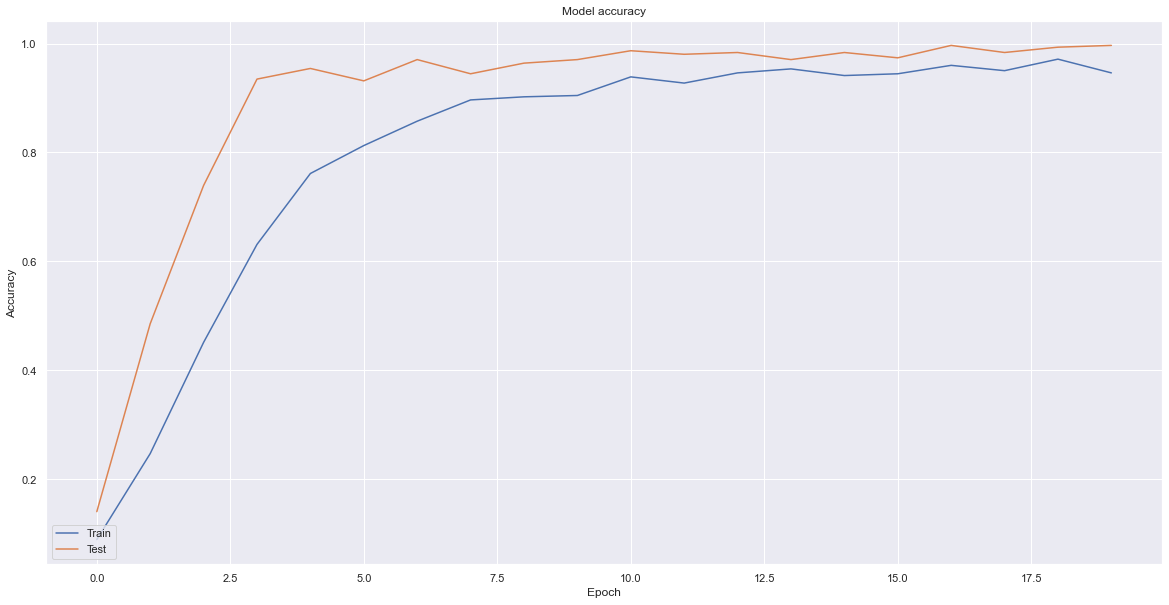

In [143]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
#plt.show()
plt.savefig('accuracy.pdf', dpi = 700)

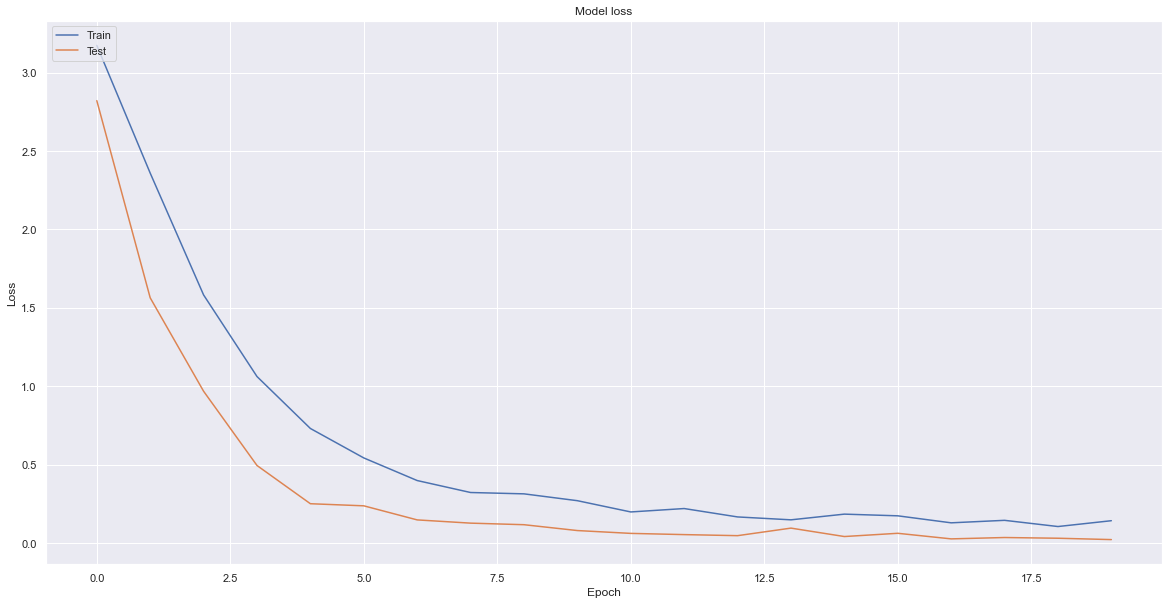

In [144]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('loss.pdf', dpi = 700)

In [118]:
! pip install pydot

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [145]:
from tensorflow.keras.utils import plot_model

#model = ResNet50(weights='imagenet')
plot_model(model, to_file='model.pdf', dpi = 700, show_shapes=True)

In [146]:
# Step 8 - Make prediction
res = model.predict(X_test)

In [147]:
actions[np.argmax(res[0])]

'V'

In [148]:
actions[np.argmax(y_test[0])]

'V'

In [149]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score, precision_recall_fscore_support

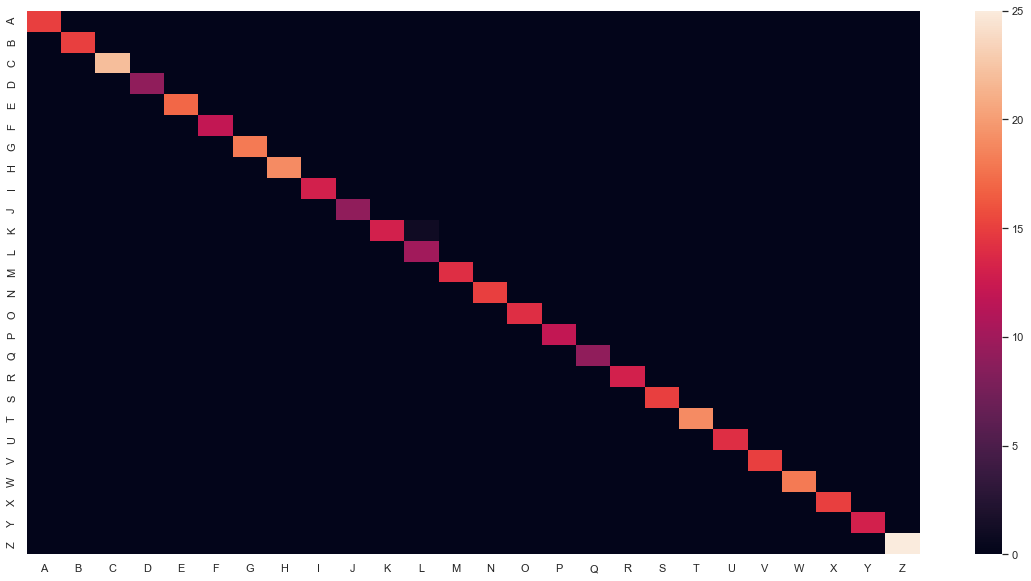

In [150]:
import seaborn as sns
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

cf_matr = confusion_matrix(ytrue, yhat)
sns.set(rc = {'figure.figsize':(20, 10)})
hmap = sns.heatmap(cf_matr,xticklabels=actions,yticklabels=actions)
hmap
figure = hmap.get_figure()    
figure.savefig('Confusion_matrix.pdf', dpi=700)

In [151]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [152]:
conf_matrix = multilabel_confusion_matrix(ytrue, yhat)
print("Accuracy Score: {}".format(accuracy_score(ytrue, yhat)))

Accuracy Score: 0.9973958333333334


In [153]:
from sklearn.metrics import fbeta_score 
(precision, recall, f1_score, _) = precision_recall_fscore_support(ytrue, yhat, average='macro')
print("Precision Score: {}\nRecall Score: {}\nF1 Score: {}".format(precision, recall, f1_score))
print("F Beta Score for Beta as 0.5 = {}".format(fbeta_score(ytrue, yhat, average='macro', beta=0.5)))

Precision Score: 0.9965034965034966
Recall Score: 0.9972527472527474
F1 Score: 0.9967439967439967
F Beta Score for Beta as 0.5 = 0.9965682465682465


In [154]:
from sklearn.metrics import classification_report
print(classification_report(ytrue, yhat, target_names=actions))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        15
           B       1.00      1.00      1.00        15
           C       1.00      1.00      1.00        22
           D       1.00      1.00      1.00         9
           E       1.00      1.00      1.00        17
           F       1.00      1.00      1.00        12
           G       1.00      1.00      1.00        18
           H       1.00      1.00      1.00        19
           I       1.00      1.00      1.00        13
           J       1.00      1.00      1.00         9
           K       1.00      0.93      0.96        14
           L       0.91      1.00      0.95        10
           M       1.00      1.00      1.00        14
           N       1.00      1.00      1.00        15
           O       1.00      1.00      1.00        14
           P       1.00      1.00      1.00        12
           Q       1.00      1.00      1.00         9
           R       1.00    

In [155]:
from sklearn.metrics import hamming_loss
print("Hamming Loss: {}".format(hamming_loss(ytrue, yhat)))

Hamming Loss: 0.0026041666666666665


In [156]:
from sklearn.metrics import jaccard_score, matthews_corrcoef
print("Jaccard Score: {}".format(jaccard_score(ytrue, yhat, average='macro')))
print("Matthews correlation coefficient: {}".format(matthews_corrcoef(ytrue, yhat)))

Jaccard Score: 0.9937562437562437
Matthews correlation coefficient: 0.9972917361297573


In [157]:
import pandas as pd
import matplotlib.pyplot as plt


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [158]:
actions[12:]

array(['M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
       'Z'], dtype='<U1')

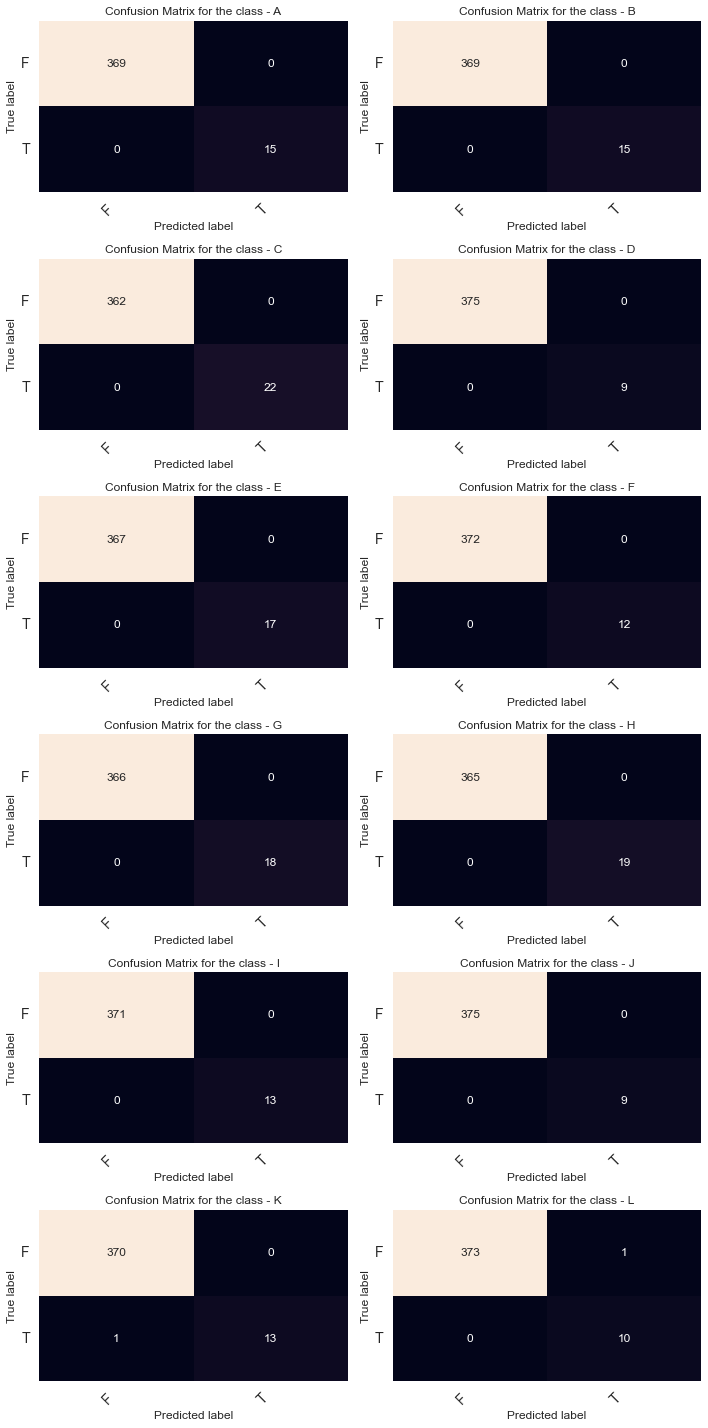

In [159]:
fig, ax = plt.subplots(6, 2, figsize=(10, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix[0:12], actions[0:12]):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
#plt.show()
plt.savefig('conf_mat.pdf', dpi = 700)

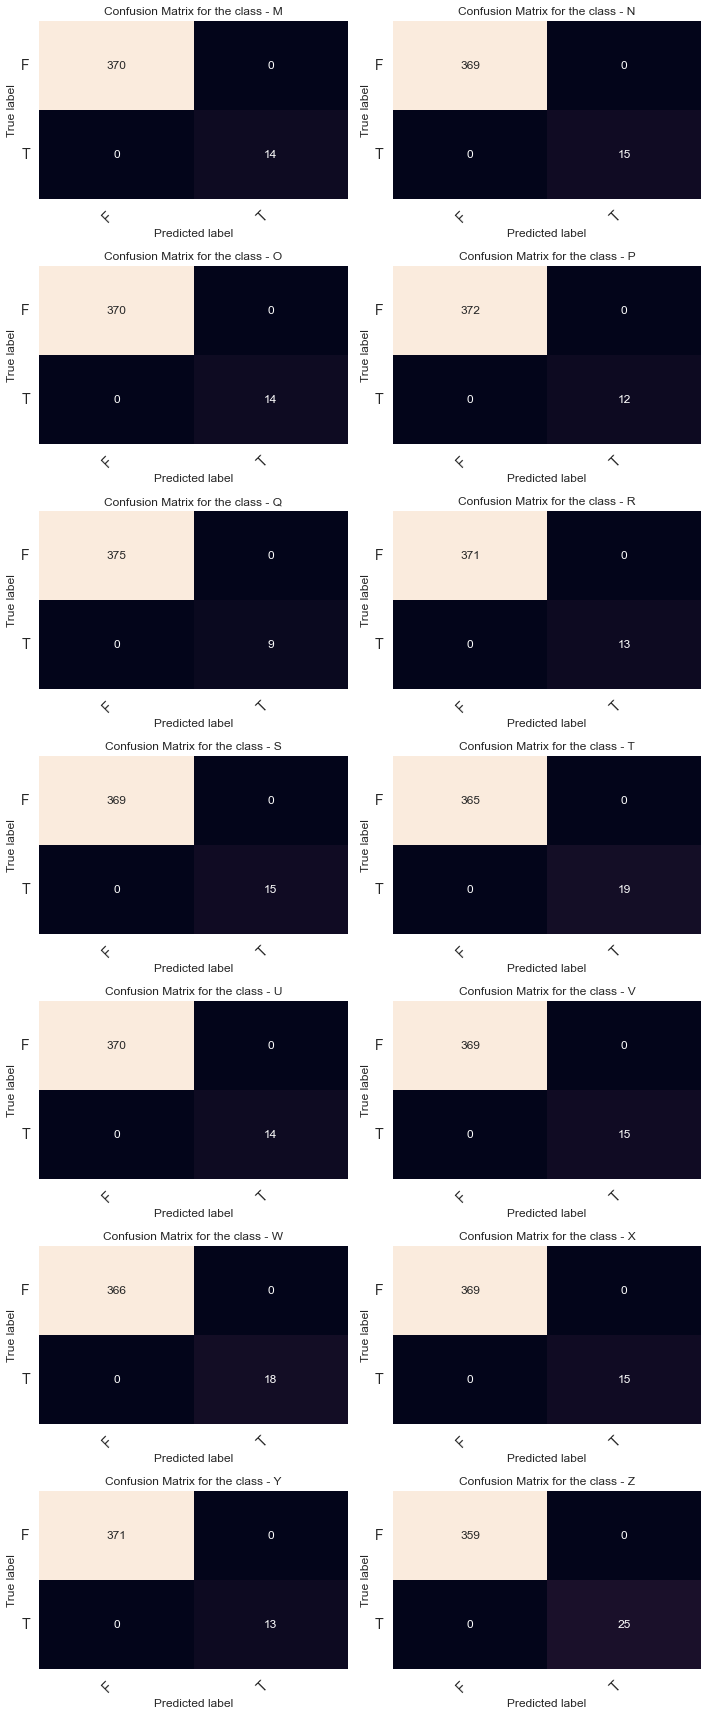

In [160]:
fig, ax = plt.subplots(7, 2, figsize=(10, 24))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix[12:], actions[12:]):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
#plt.show()
plt.savefig('conf_mat2.pdf', dpi = 700)

In [161]:
# Uncomment to save your model
model.save('saved_weights.h5')

In [162]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import lite

SAVED_MODEL = "saved_models"
tf.saved_model.save(model, SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models\assets


In [163]:
#sigmodel = hub.load(SAVED_MODEL)
TFLITE_MODEL = "tflite_models/sign.tflite"
TFLITE_QUANT_MODEL = "tflite_models/sign_quant.tflite"

In [165]:
def convert_to_tflite():
    converter = lite.TFLiteConverter.from_keras_model(model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.experimental_new_converter = True
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                           tf.lite.OpsSet.SELECT_TF_OPS]

    converted_tflite_model = converter.convert()
    open(TFLITE_MODEL, "wb").write(converted_tflite_model)

    converter = lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    converter.experimental_new_converter = True
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                           tf.lite.OpsSet.SELECT_TF_OPS]

    tflite_quant_model = converter.convert()
    open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

In [166]:
convert_to_tflite()

INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmpxj_ni1jz\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmprcau4ltk\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmprcau4ltk\assets


In [169]:
def use_tflite(X_test, y_test):
    X_test = np.float32(X_test)
    y_test = np.float32(y_test)
    
    tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    tflite_interpreter.resize_tensor_input(
        input_details[0]['index'], X_test.shape)
    tflite_interpreter.resize_tensor_input(
        output_details[0]['index'], y_test.shape)
    tflite_interpreter.allocate_tensors()

    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    # Load quantized TFLite model
    tflite_interpreter_quant = tf.lite.Interpreter(
        model_path=TFLITE_QUANT_MODEL)

    # Learn about its input and output details
    input_details = tflite_interpreter_quant.get_input_details()
    output_details = tflite_interpreter_quant.get_output_details()

    # Resize input and output tensors
    tflite_interpreter_quant.resize_tensor_input(
        input_details[0]['index'], X_test.shape)
    tflite_interpreter_quant.resize_tensor_input(
        output_details[0]['index'], y_test.shape)
    tflite_interpreter_quant.allocate_tensors()

    input_details = tflite_interpreter_quant.get_input_details()
    output_details = tflite_interpreter_quant.get_output_details()

    # Run inference
    tflite_interpreter_quant.set_tensor(input_details[0]['index'], X_test)

    tflite_interpreter_quant.invoke()

    tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(
        output_details[0]['index'])
#print("\nPrediction results shape:", tflite_q_model_predictions.shape)

In [ ]:
#use_tflite(X_test, y_test)

In [ ]:
#new_actions = np.array(['C', 'O'])
#new_label_map = {label:num for num, label in enumerate(new_actions)}
#new_label_map

In [ ]:
# CNN Model
#model = Sequential()

#model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 126)))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Flatten())

# model.add(Dense(64,activation ="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation ="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(new_actions.shape[0],activation ="softmax"))

In [ ]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# sequences, labels = [], []
# for action in new_actions:
#     for sequence in range(no_sequences):
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res)
#         sequences.append(window)
#         labels.append(new_label_map[action])

In [ ]:
#X = np.array(sequences)

In [ ]:
#y = to_categorical(labels).astype(int)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
#X_train.shape

In [ ]:
#y_train.shape

In [ ]:
#model.fit(X_train, y_train, epochs=100)

In [ ]:
#model.summary()

In [ ]:
# Step 8 - Make prediction
#res = model.predict(X_test)

In [ ]:
# yhat = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=1)
# yhat = np.argmax(yhat, axis=1)

# cf_matr2 = confusion_matrix(ytrue, yhat)
# sns.set(rc = {'figure.figsize':(5, 4)})
# hmap2 = sns.heatmap(cf_matr2,xticklabels=new_actions,yticklabels=new_actions)
# hmap2
# figure = hmap2.get_figure()    
# figure.savefig('Confusion_matrixCO.pdf', dpi=700)

In [ ]:
# ytrue = np.argmax(y_test, axis=1).tolist()
# yhat = np.argmax(model.predict(X_test), axis=1).tolist()
# accuracy_score(ytrue, yhat)

In [ ]:
# # Uncomment to save your model
# model.save('actionCO.h5')

In [ ]:
# new_actions = np.array(['M', 'N'])
# new_label_map = {label:num for num, label in enumerate(new_actions)}
# new_label_map

In [ ]:
# # CNN Model
# model = Sequential()

# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 126)))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Flatten())

# model.add(Dense(64,activation ="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation ="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(new_actions.shape[0],activation ="softmax"))

In [ ]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# sequences, labels = [], []
# for action in new_actions:
#     for sequence in range(no_sequences):
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res)
#         sequences.append(window)
#         labels.append(new_label_map[action])

In [ ]:
#X = np.array(sequences)

In [ ]:
#y = to_categorical(labels).astype(int)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
#X_train.shape

In [ ]:
#y_train.shape

In [ ]:
#model.fit(X_train, y_train, epochs=100)

In [ ]:
#model.summary()

In [ ]:
# Step 8 - Make prediction
#res = model.predict(X_test)

In [ ]:
# yhat = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=1)
# yhat = np.argmax(yhat, axis=1)

# cf_matr3 = confusion_matrix(ytrue, yhat)
# sns.set(rc = {'figure.figsize':(5, 4)})
# hmap3 = sns.heatmap(cf_matr3,xticklabels=new_actions,yticklabels=new_actions)
# hmap3
# figure = hmap3.get_figure()    
# figure.savefig('Confusion_matrixMN.pdf', dpi=700)

In [ ]:
# yhat = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=1).tolist()
# yhat = np.argmax(model.predict(X_test), axis=1).tolist()
# accuracy_score(ytrue, yhat)

In [ ]:
#plot_model(model, to_file='modelCO.pdf', dpi = 700, show_shapes=True)

In [ ]:
# Uncomment to save your model
#model.save('actionMN.h5')